<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch8-Integrated_Planning_Learning/Dyna_Q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

# Integrated Planning, Acting and Learning using DYNA-Q

## Dyna Maze

In [2]:
VALID = 0
START = 1
PATH = 2
FINISH = 3
OBSTACLE = 4

def get_maze():
  nRows = 6
  nCols = 9
  map = np.zeros((nRows,nCols),dtype=np.int8)
  map[2,0] = START
  map[0,8] = FINISH
  map[1:4,2] = OBSTACLE
  map[4,5] = OBSTACLE
  map[0:3,7] = OBSTACLE
  return map

def plot_circuit(fig,map,num):
  nRows,nCols = map.shape
  # create discrete colormap
  #cmap = colors.ListedColormap(['red', 'blue'])
  cmap = colors.ListedColormap(['white','red','blue','green','black'])
  bounds = [0,0.1,3]
  norm = colors.BoundaryNorm(bounds, cmap.N)
  ax = fig.add_subplot(1,1,num)
  ax.imshow(map, cmap=cmap)#, norm=norm)

  ### draw gridlines
  # ax = plt.gca();
  ax.set_xticks(np.arange(-0.5, nCols+0.5, 1));
  ax.set_yticks(np.arange(-0.5, nRows+0.5, 1));
  ax.set_xticklabels(np.arange(-0.5, nCols+0.5, 1));
  ax.set_yticklabels(np.arange(-0.5, nRows+0.5, 1));
  ax.grid(color='k', linestyle='-', linewidth=1)

  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')

### Visualize Map

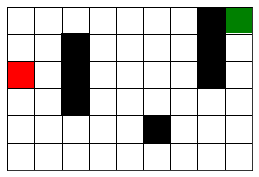

In [3]:
map = get_maze()
fig = plt.figure(figsize=(5,3))
plot_circuit(fig,map,1)

### Constant Parameters

In [ ]:
num_trials = 30
num_episodes = 50
alpha = 0.1
gamma = 0.95
epsilon = 0.1
hv_actions = [[-1,0],[0,1],[1,0],[0,-1]]
start = [2,0]
goal  = [0,8]

In [ ]:
def move(state,action):
  new_state = [max(0,min(map.shape[0]-1,state[0]+action[0])),max(0,min(map.shape[1]-1,state[1]+action[1]))]
  if map[new_state[0],new_state[1]] == OBSTACLE:
    return state
  return new_state

def target_policy(Q,pos,actions,epsilon):
  nA = len(actions)
  action_prob = epsilon/float(nA)*np.ones((nA,))
  maxQ = np.max(Q[pos[0],pos[1],:])
  idx = np.where(Q[pos[0],pos[1],:] == maxQ)[0]
  action_prob[idx] += (1-epsilon)/float(len(idx))
  return np.random.choice(range(nA),p=action_prob)

def get_action_idx(action):
  return np.where(np.sum(np.abs(actions-action),1) == 0)[0][0]

def play(map,init):
  curr_state = np.copy(init)
  reward = 0
  traj = [curr_state]
  action_prob = []
  while not check_termination(map,curr_state):
    reward -= 1
    act,prob = behavior_policy(map,curr_state)
    next_state,new_vel = move(curr_state,act)
    # print("################")
    # print(curr_state)
    # print(new_vel)
    # print(next_state)
    if check_OutOfBounds(map,next_state):
      return -1,traj,action_prob
      # curr_state = init_state(map)
      # traj = [curr_state]
      # action_prob = []
      # continue
    else:
      curr_state = next_state
    action_prob += [list(act) + [prob]]
    traj += [curr_state]
  return 1,traj,action_prob